In [1]:
import operator
from typing import List, Sequence, TypedDict, Annotated
from pydantic import BaseModel, Field
from langchain_google_genai import ChatGoogleGenerativeAI
from langchain_huggingface import HuggingFaceEmbeddings
from langchain_community.vectorstores import Chroma
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_community.document_loaders import DirectoryLoader, PyPDFLoader
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain.prompts import PromptTemplate
from langchain.output_parsers import PydanticOutputParser
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.output_parsers import StrOutputParser
from langchain_core.runnables import RunnablePassthrough
from langchain_core.messages import BaseMessage
from langgraph.graph import StateGraph, END
from IPython.display import Image, display
from dotenv import load_dotenv


In [2]:
# Load environment
load_dotenv()

llm_model = ChatGoogleGenerativeAI(model="gemini-1.5-flash")
embeddings = HuggingFaceEmbeddings(model_name="BAAI/bge-small-en")

d:\Agentic-AI-2.0\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# ========== Load & Store Documents ==========
loader = DirectoryLoader("data", glob="*.pdf", loader_cls=PyPDFLoader)
docs = loader.load()

text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=200, chunk_overlap=50
)
new_docs = text_splitter.split_documents(docs)
print(f"new_docs: {new_docs}")

db = Chroma.from_documents(new_docs, embeddings)
retriever = db.as_retriever(search_kwargs={"k": 3})


new_docs: [Document(metadata={'producer': 'Adobe PDF Library 15.0', 'creator': 'Adobe InDesign CC 14.0 (Windows)', 'creationdate': '2019-08-22T14:41:37-03:00', 'gts_pdfxconformance': 'PDF/X-1a:2001', 'gts_pdfxversion': 'PDF/X-1:2001', 'moddate': '2019-09-11T09:54:27-03:00', 'title': '72_6_ING.indd', 'trapped': '/False', 'source': 'data\\mental_health.pdf', 'total_pages': 9, 'page': 0, 'page_label': '1'}, page_content='1609Rev Bras Enferm. 2019;72(6):1609-17. http://dx.doi.org/10.1590/0034-7167-2018-0743\nABSTRACT\nObjective: to analyze perceptions of the Family Health Strategy (FHS) professional team'), Document(metadata={'producer': 'Adobe PDF Library 15.0', 'creator': 'Adobe InDesign CC 14.0 (Windows)', 'creationdate': '2019-08-22T14:41:37-03:00', 'gts_pdfxconformance': 'PDF/X-1a:2001', 'gts_pdfxversion': 'PDF/X-1:2001', 'moddate': '2019-09-11T09:54:27-03:00', 'title': '72_6_ING.indd', 'trapped': '/False', 'source': 'data\\mental_health.pdf', 'total_pages': 9, 'page': 0, 'page_label'

In [4]:
# ========== Agent State ==========
class AgentState(TypedDict):
    messages: Annotated[Sequence[str], operator.add]


# ========== Output Parser ==========
class TopicSelection(BaseModel):
    Topic: str = Field(description="selected topic")
    Reasoning: str = Field(description="reasoning behind topic selection")


parser = PydanticOutputParser(pydantic_object=TopicSelection)


In [5]:
# ========== Supervisor Node ==========
def supervisor_node(state: AgentState):
    question = state["messages"][-1]

    prompt = PromptTemplate(
        template="""
        Classify the user query into one of these: [Mental Health, Real Time Info, Not Related].
        Rule for classifying:
        If question talks about mental health or some similar information, then classify it to 'Mental health'.
        If question talks about sonme recent or latest information, then classify it to 'Real Time Info'.
        Otherwise, classify it to 'Not Related'.
        Return reasoning too.

        Query: {question}
        {format_instructions}
        """,
        input_variables=["question"],
        partial_variables={
            "format_instructions": parser.get_format_instructions()
        },
    )

    chain = prompt | llm_model | parser
    response = chain.invoke({"question": question})
    print(f"response: {response}")
    return {"messages": [response.Topic]}


In [ ]:
# ========== Supervisor Node ==========
def supervisor_node(state: AgentState):
    question = state["messages"][-1]

    prompt = PromptTemplate(
        template="""
        Classify the user query into one of these: [Mental Health, Real Time Info, Not Related].
        Rule for classifying:
        If question talks about mental health or some similar information, then classify it to 'Mental health'.
        If question talks about sonme recent or latest information, then classify it to 'Real Time Info'.
        Otherwise, classify it to 'Not Related'.
        Return reasoning too.

        Query: {question}
        {format_instructions}
        """,
        input_variables=["question"],
        partial_variables={
            "format_instructions": parser.get_format_instructions()
        },
    )

    chain = prompt | llm_model | parser
    response = chain.invoke({"question": question})
    print(f"response: {response}")
    return {"messages": [response.Topic]}


In [6]:
# ========== Router Function ==========
def router(state: AgentState):
    last = state["messages"][-1].lower()
    print(f"last: {last}")
    if (
        "real time" in last
        or "live" in last
        or "latest" in last
        or "current" in last
    ):
        return "Web"
    elif "mental" in last or "mind" in last:
        return "RAG"
    else:
        return "LLM"

In [7]:
# ========== Helper ==========
def format_docs(docs):
    return "\n\n".join(doc.page_content for doc in docs)


In [8]:
# ========== RAG Node ==========
def rag_node(state: AgentState):
    question = state["messages"][0]

    prompt = PromptTemplate(
        template="""Use the context below to answer concisely. If unknown, say so.
        Question: {question}
        Context: {context}
        Answer:""",
        input_variables=["context", "question"],
    )

    chain = (
        {"context": retriever | format_docs, "question": RunnablePassthrough()}
        | prompt
        | llm_model
        | StrOutputParser()
    )
    result = chain.invoke(question)
    print(f"result from rag: {result}")
    return {"messages": [result]}



In [9]:
# ========== LLM Node ==========
def llm_node(state: AgentState):
    question = state["messages"][0]
    prompt = (
        f"Answer the following question using your own knowledge: {question}"
    )
    response = llm_model.invoke(prompt)
    print(f"response from llm: {response}")
    return {"messages": [response.content]}

In [10]:
# ========== Web Crawler Node (Mocked) ==========
def web_node(state: AgentState):
    query = state["messages"][0]
    print(f"state: {state}")
    tool = TavilySearchResults()
    response = tool.invoke({"query": query})
    print(f"response from web: {response}")
    return {"messages": [response[0].get("content")]}

In [11]:
# ========== Web Crawler Node (Mocked) ==========
def web_node(state: AgentState):
    query = state["messages"][0]
    print(f"state: {state}")
    tool = TavilySearchResults()
    response = tool.invoke({"query": query})
    print(f"response from web: {response}")
    return {"messages": [response[0].get("content")]}

In [12]:
# ========== Validator Node ==========
def validator_node(state: AgentState):
    print(f"state: {state}")
    answer = state["messages"][-1]
    if "I don't know" in answer or len(answer.strip()) < 10:
        print("Validation Failed ❌")
        return {"messages": ["__RETRY__"]}
    print("Validation Passed ✅")
    return {"messages": [answer]}

In [13]:
# ========== Retry Router ==========
def retry_router(state: AgentState):
    print(f"state: {state}")
    if state["messages"][-1] == "__RETRY__":
        return "Supervisor"
    return "Final"


In [14]:
# ========== Final Output Node ==========
def final_node(state: AgentState):
    return {"messages": [f"✅ Final Answer: {state['messages'][-1]}"]}


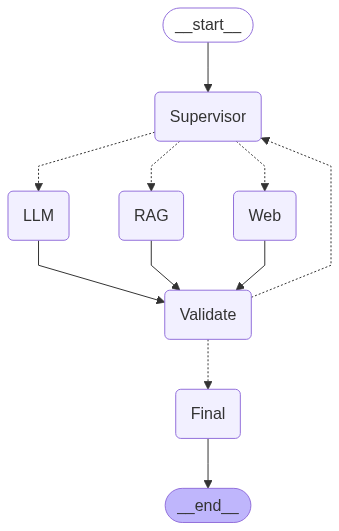

In [15]:
# ========== Define Workflow ==========
workflow = StateGraph(AgentState)

workflow.add_node("Supervisor", supervisor_node)
workflow.add_node("RAG", rag_node)
workflow.add_node("LLM", llm_node)
workflow.add_node("Web", web_node)
workflow.add_node("Validate", validator_node)
workflow.add_node("Final", final_node)

workflow.set_entry_point("Supervisor")

workflow.add_conditional_edges(
    "Supervisor", router, {"RAG": "RAG", "LLM": "LLM", "Web": "Web"}
)

workflow.add_edge("RAG", "Validate")
workflow.add_edge("LLM", "Validate")
workflow.add_edge("Web", "Validate")

workflow.add_conditional_edges(
    "Validate", retry_router, {"Supervisor": "Supervisor", "Final": "Final"}
)

workflow.add_edge("Final", END)

# ========== Compile App ==========
app = workflow.compile()

# ========== Display App Workflow==========
display(Image(app.get_graph().draw_mermaid_png()))


In [16]:
# ========== Example Run ==========
if __name__ == "__main__":
    state = {"messages": ["what is AI"]}
    result = app.invoke(state)
    print(f"Final response from app: {result["messages"][-1]}")


response: Topic='Not Related' Reasoning='The question "what is AI" is a general inquiry about artificial intelligence and does not pertain to mental health or real-time information.'
last: not related
response from llm: content="Artificial intelligence (AI) is a broad field encompassing the development of computer systems capable of performing tasks that typically require human intelligence.  These tasks include learning, reasoning, problem-solving, perception (like image and speech recognition), and natural language understanding.  AI systems achieve this through various techniques, including machine learning (where systems learn from data without explicit programming), deep learning (a subset of machine learning using artificial neural networks with multiple layers), and expert systems (which encode human knowledge to make decisions).  It's important to note that AI is not a single technology but rather a collection of approaches and techniques aimed at creating intelligent machines.